In [2]:
import numpy as np
import math
import scipy as sp
from scipy import optimize
from numpy import genfromtxt
import pandas as pd 
import pymc3 as pm
import arviz as az
import statistics as stats
import matplotlib.pyplot as plt
from numpy import random

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Setup

In [100]:
data = genfromtxt("Full Subjective Value Table.csv", delimiter=',', dtype=str)
#Column titles: Trial Number	Stimulus Time	Response Time	SS amount	LL amount	SS delay	LL delay	Response	SS SV	LL SV	k	beta	ID	Day	Date	Time	LL	AIC	BIC	r2	correct percent
IDs = np.array(data[1:,12])
Days = np.array(data[1:,13])
Dates = np.array(data[1:,14])
Times = np.array(data[1:,15])
Identifiers = np.array([i + j + k + l for i, j, k, l in zip(IDs, Days, Dates, Times)])

AICs = np.array(data[1:,17], dtype=float)
r2s = np.array(data[1:,19], dtype=float)

SSAmount = np.array(data[1:,3], dtype=float)
SSDelay = np.array(data[1:,5], dtype=float)
LLAmount = np.array(data[1:,4], dtype=float)
LLDelay = np.array(data[1:,6], dtype=float)
Choices = np.array(data[1:,7], dtype=int)
Betas = np.array(data[1:,11], dtype=float)

Ks = np.array(data[1:,10], dtype=float)

groups = np.full(len(IDs),100000)
alreadycoded = []
indextocount = 0

for identifier in Identifiers:
    if identifier not in alreadycoded:
        groups[Identifiers==identifier] = indextocount
        indextocount = indextocount + 1
        alreadycoded.append(identifier)

Do the good stuff

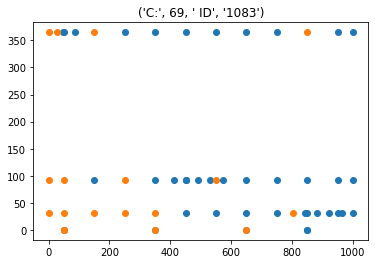

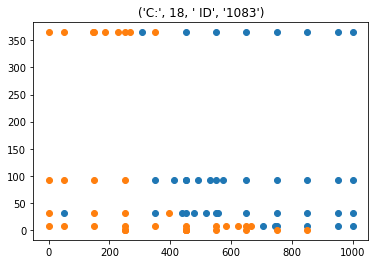

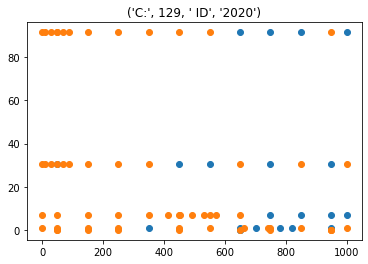

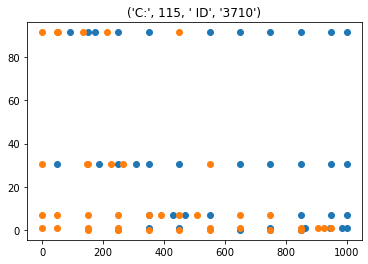

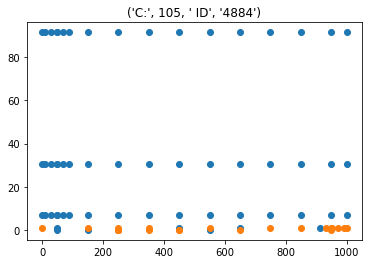

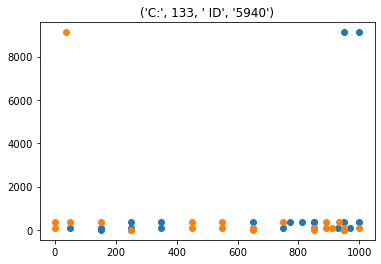

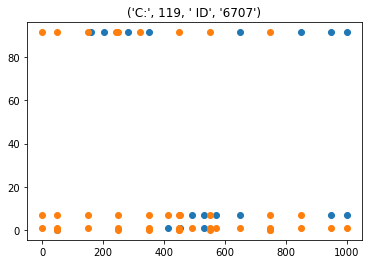

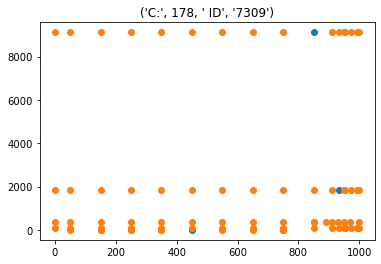

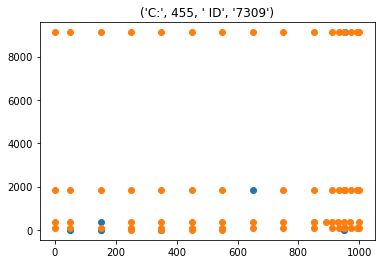

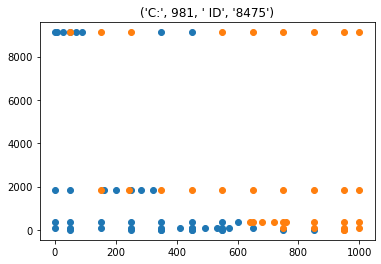

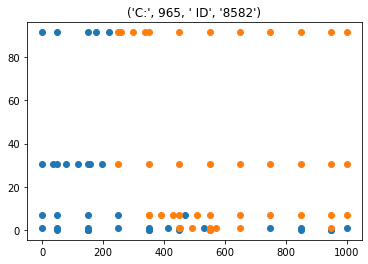

In [107]:
# Y'all probably won't use this much, so I won't spend too much time on this here. I really like it though! I think this turned out to be a good way of identifying files that are a problem. 
# I don't think this should be used to exclude participant sessions, but I do think that it can be used to show mercy to the modeling strategies. This can identify choices that are inherently inconsistent, meaning that no hyperbolic discounting model could possibly fit a good curve. The ideal would be to determine a maximum possible accuracy, but that might be an adventure.

GBI = []
for group in np.unique(groups[:int((groups.size))]):  #/16
    tempbools = (groups==group)*(SSDelay==0)
    tImmA = SSAmount[(tempbools)*(Choices==0)]
    #tSSd = SSDelay[tempbools]
    tImmD = LLDelay[(tempbools)*(Choices==0)]
    tDelA = SSAmount[(tempbools)*(Choices==1)]
    tDelD = LLDelay[(tempbools)*(Choices==1)]
    countwrong = 0
    counttotal = 0
    #print((groups[groups==group]).size)

    # Loops through choice-to-choice relationships, not through choices themselves. 
    # tick up points for inconsistent choices

    for i1 in range(tImmA.size):
        for i2 in range(tDelA.size):
            counttotal = counttotal + 1
            if ((tDelA[i2]>=tImmA[i1])&(tDelD[i2]>=tImmD[i1])):  # If you graph a session and then find these inequalities, you'll see that they represent inherently inconsistent choices.
                countwrong = countwrong + 1

    if (countwrong>100 or (IDs[np.unique(Identifiers, return_index = True)[1]])[group] == "1083"):
        plt.figure()
        plt.scatter(tImmA,tImmD)
        plt.scatter(tDelA, tDelD)
        plt.title(("C:",countwrong," ID", (IDs[np.unique(Identifiers, return_index = True)[1]])[group]))
        plt.show


    # tick up points for convex/concave issues
    #tempMaxList = []
    #tempUniqueTimes = np.unique(tDelD)
    #for time in tempUniqueTimes:
    #    maxAinDelay = np.max(tDelA[tDelD==time])
    #    tempMaxList.append(maxAinDelay)
    #for i in range(1,len(tempMaxList)):
    #    slope = (tempMaxList[i]-tempMaxList[i-1])/(tempUniqueTimes[i]-tempUniqueTimes[i-1])
    #    for checkTime in range(i):
            



    GBI.append(countwrong) # /counttotal
    #print(countwrong)
    if False:
        plt.figure()
        plt.scatter(tImmD,tImmA)
        plt.scatter(tDelD,tDelA)
        plt.title(("Group",group," Wrong",countwrong))
        plt.show
#print(np.unique(groups)[:7])
#print(GBI[:7])

Compare with random

In [ ]:
randomXs = []
randomYs = []
for i in range(10):
    for ii in range(10):
        randomXs.append(i)
        randomYs.append(ii)

randomXs = np.array(randomXs)
randomYs = np.array(randomYs)

sum = 0
for ccc in range(1000):
    randomPicks = random.randint(2,size=100)
    #print(randomPicks)
    tImmA_r = randomYs[randomPicks==0]
    tDelA_r = randomYs[randomPicks==1]
    tImmD_r = randomXs[randomPicks==0]
    tDelD_r = randomXs[randomPicks==1]

    countwrong = 0
    for i1 in range(tImmA_r.size):
        for i2 in range(tDelA_r.size):
            counttotal = counttotal + 1
            if ((tDelA_r[i2]>=tImmA_r[i1])&(tDelD_r[i2]>=tImmD_r[i1])):
                countwrong = countwrong + 1
    sum += countwrong
    if (ccc%100 == 0):
        print(sum/(ccc+1))


plt.figure()
plt.scatter(tImmA_r,tImmD_r)
plt.scatter(tDelA_r, tDelD_r)
plt.show
countwrong


Find IDs corresponding to max vals

In [78]:
#Find IDs corresponding to max vals
#fun fact: 731.5 is the average for totally random picks on a 10X10 grid.

print((IDs[np.unique(Identifiers, return_index = True)[1]])[np.argmax(np.array(GBI))])
print(np.array(GBI))
print((IDs[np.unique(Identifiers, return_index = True)[1]]))

8475
[ 69  18   3   2  19  41 129  30  15  20  33  22  13   0   0   5   2   7
   0   0   2  67  17   4  27   6   6   7 115  21  66   3   0  50  12  58
  14  18   0   2   0  34  35  25  39  68 105  29  16  35  16  57  56  15
   9  25  26   4   4 133   0   5  21   0  36  68  34   5  23   5   3  13
  35   0  61 119  30  11   1   0  57  77 178 455  23  26  34  28   2  27
  46  17   6   9   0   6   6  10  26  77   0  94 981   9  39   1  14 965
   0   1  28   1  25  44  14  20]
['1083' '1083' '1539' '1539' '2008' '2008' '2020' '2020' '2042' '2042'
 '2399' '2475' '2475' '2503' '2503' '2506' '2506' '2874' '2874' '3278'
 '3278' '3458' '3546' '3546' '3638' '3638' '3687' '3687' '3710' '3812'
 '3812' '3924' '3924' '3937' '4292' '4292' '4513' '4513' '4513' '4556'
 '4556' '4776' '4776' '4805' '4805' '4884' '4884' '4884' '5334' '5625'
 '5625' '5667' '5667' '5764' '5764' '5897' '5897' '5900' '5900' '5940'
 '5940' '6059' '6059' '6269' '6269' '6281' '6281' '6382' '6463' '6463'
 '6617' '6624' '6624' '663

Comparison between GBI and other model fit measures

In [66]:
# This is fun! The GBI ("Gorman Bogusness Index" (or alternatively "Goofy Behavior Index")) correlates reasonably well with AIC and r2.

if False:
    print(np.unique(groups,return_index=True))
    print("1")
    print(np.unique(groups,return_index=True)[1])
    print("2")
    print(AICs[np.unique(groups,return_index=True)[1]])
    print("3")
    print(AICs[np.unique(groups,return_index=True)[1]].shape)
    print(np.array(GBI).shape)

print(np.corrcoef(np.array(GBI),AICs[np.unique(groups,return_index=True)[1]])[1,0])
print(np.corrcoef(np.array(GBI),r2s[np.unique(groups,return_index=True)[1]])[1,0])

0.5689194546153589
-0.5506055774833976
